In [19]:
import zarr
import os
import pandas as pd
import xarray as xr
import numpy as np

In [20]:
# Read the Zarr dataset using Xarray with automatic chunking for Dask
# ds = xr.open_zarr('/Trex/case_results/i.e215.I2000Clm50SpGs.hw_production.02/research_results/zarr/3Dvars', chunks='auto')
ds = xr.open_zarr('/Trex/case_results/i.e215.I2000Clm50SpGs.hw_production.02/research_results/zarr/3Dvars')
core_vars = ['TSA', 'TSA_R', 'TSA_U', 'WBA', 'WBA_R', 'WBA_U', 'HW']
# ds = ds[core_vars]
ds

<xarray.Dataset>
Dimensions:        (time: 262800, lat: 192, lon: 288)
Coordinates:
  * lat            (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon            (lon) float32 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * time           (time) datetime64[ns] 1985-01-01 ... 2014-12-31T23:00:00
Data variables: (12/53)
    APPAR_TEMP     (time, lat, lon) float32 dask.array<chunksize=(2232, 96, 144), meta=np.ndarray>
    APPAR_TEMP_R   (time, lat, lon) float32 dask.array<chunksize=(2232, 96, 144), meta=np.ndarray>
    APPAR_TEMP_U   (time, lat, lon) float32 dask.array<chunksize=(2232, 96, 144), meta=np.ndarray>
    EFLX_LH_TOT    (time, lat, lon) float32 dask.array<chunksize=(2232, 96, 144), meta=np.ndarray>
    EFLX_LH_TOT_R  (time, lat, lon) float32 dask.array<chunksize=(2232, 96, 144), meta=np.ndarray>
    EFLX_LH_TOT_U  (time, lat, lon) float32 dask.array<chunksize=(2232, 96, 144), meta=np.ndarray>
    ...             ...
    VAPOR_PRES_U   (time, lat, lon) float32 dask.array<chunksize=(2232, 96, 144), meta=np.ndarray>
    WASTEHEAT      (time, lat, lon) float32 dask.array<chunksize=(2232, 96, 144), meta=np.ndarray>
    WBA            (time, lat, lon) float32 dask.array<chunksize=(2232, 96, 144), meta=np.ndarray>
    WBA_R          (time, lat, lon) float32 dask.array<chunksize=(2232, 96, 144), meta=np.ndarray>
    WBA_U          (time, lat, lon) float32 dask.array<chunksize=(2232, 96, 144), meta=np.ndarray>
    WIND           (time, lat, lon) float32 dask.array<chunksize=(2232, 96, 144), meta=np.ndarray>
Attributes: (12/40)
    Conventions:                               CF-1.0
    Initial_conditions_dataset:                i.e215.I2000Clm50SpGs.hw_spinu...
    PFT_physiological_constants_dataset:       clm5_params.c171117.nc
    Surface_dataset:                           surfdata_0.9x1.25_hist_16pfts_...
    Time_constant_3Dvars:                      ZSOI:DZSOI:WATSAT:SUCSAT:BSW:H...
    Time_constant_3Dvars_filename:             ./i.e215.I2000Clm50SpGs.hw_pro...
    ...                                        ...
    revision_id:                               $Id: histFileMod.F90 42903 201...
    source:                                    Community Land Model CLM4.0
    time_period_freq:                          hour_1
    title:                                     CLM History file information
    username:                                  jguo
    version:                                   release-cesm2.1.5

<xarray.DataArray 'TSA' ()>
array(229735.22, dtype=float32)
Coordinates:
    time     datetime64[ns] 1985-01-01

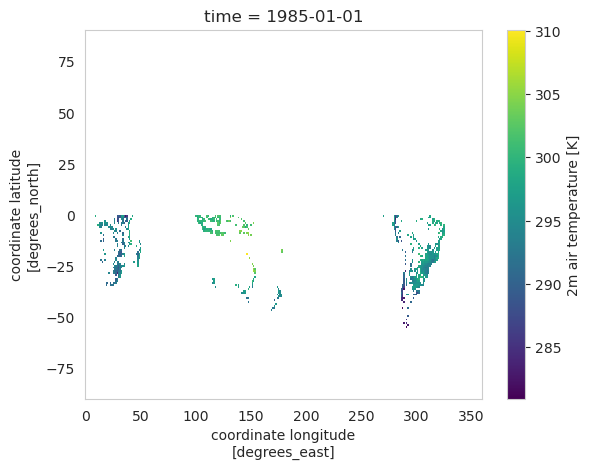

In [21]:
ds.TSA.isel(time=0).plot()
ds.TSA.isel(time=0).sum().compute()


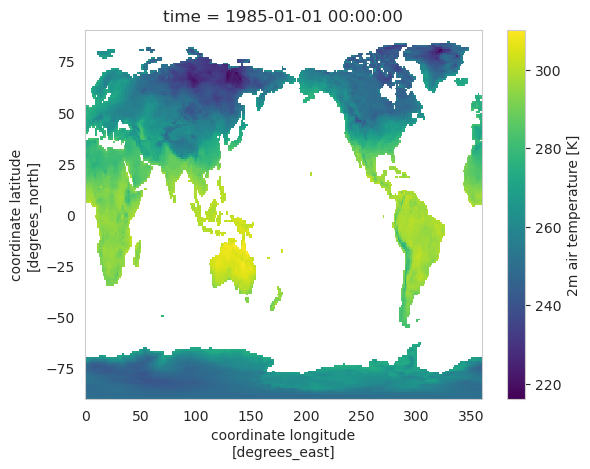

In [22]:
#read in netcdf file i.e215.I2000Clm50SpGs.hw_production.02.clm2.h2.1985-01-01-00000.nc
ds_netcdf = xr.open_dataset('/Trex/case_results/i.e215.I2000Clm50SpGs.hw_production.02/sim_results/hourly/i.e215.I2000Clm50SpGs.hw_production.02.clm2.h2.1985-01-01-00000.nc')
ds_netcdf.TSA.isel(time=0).plot()





In [23]:
type(ds.HW.isel(time=0).values[0][0])

numpy.bool_

#  Select Urban cells only

In [24]:
#get first year from ds
ds_1985 = ds.sel(time=slice('1985-01-01', '1985-12-31'))

In [25]:
# Identify lat and lon values where the mask is True
mask = ds_netcdf.isel(time=22)['TSA_U'].notnull()
mask.sum()

<xarray.DataArray 'TSA_U' ()>
array(4241)
Coordinates:
    time     object 1985-01-01 22:00:00.001717

In [26]:
lat_values = ds_1985['lat'].values[np.any(mask, axis=1)]
lon_values = ds_1985['lon'].values[np.any(mask, axis=0)]


<xarray.DataArray 'TSA' ()>
array(229735.2, dtype=float32)
Coordinates:
    time     datetime64[ns] 1985-01-01
<xarray.DataArray 'TSA' ()>
array(229735.22, dtype=float32)
Coordinates:
    time     datetime64[ns] 1985-01-01


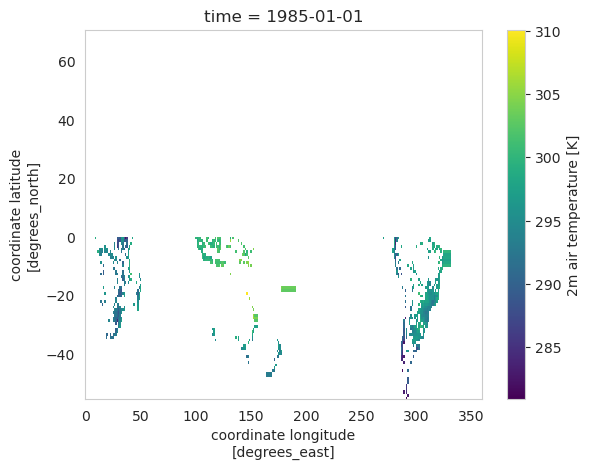

In [27]:

# Select only the data corresponding to the True mask values for 'lat' and 'lon'
ds_1985_selected = ds_1985.sel(lat=lat_values, lon=lon_values)
ds_1985_selected.TSA.isel(time=0).plot()
print(ds_1985_selected.TSA.isel(time=0).sum().compute())
print(ds.TSA.isel(time=0).sum().compute())

In [28]:
ds['UHI'] = ds.TSA_U - ds.TSA_R
ds['UBWI'] = ds.WBA_U - ds.WBA_R


In [29]:

def append_to_zarr(ds, zarr_group):
    chunk_size = {'time': 24 * 365 * 5, 'lat': 96, 'lon': 144}
    ds = ds.chunk(chunk_size)
    if os.path.exists(zarr_group):
        ds.to_zarr(zarr_group, mode='a', append_dim='time', consolidated=True)
    else:
        encoding = {var: {'compressor': zarr.Blosc(cname='zstd', clevel=3)} for var in ds.data_vars}
        ds.to_zarr(zarr_group, mode='w', encoding=encoding, consolidated=True)

In [30]:
import xarray as xr
import numpy as np

# Function to process data in smaller chunks
def process_in_chunks(ds, chunk_size, zarr_path):
    # Determine the number of time steps
    num_time_steps = ds.dims['time']

    # Iterate over the dataset in chunks
    for start in range(0, num_time_steps, chunk_size):
        end = start + chunk_size
        print(f"Processing time steps {start} to {min(end, num_time_steps)}")

        # Select the chunk
        ds_chunk = ds.isel(time=slice(start, end))

        # Compute the boolean indexer for the current chunk
        hw_computed = ds_chunk.HW.compute()

        # Apply the condition and compute the chunk
        ds_hw_chunk = ds_chunk.where(hw_computed, drop=True).compute()
        ds_no_hw_chunk = ds_chunk.where(~hw_computed, drop=True).compute()

        # Append the processed chunk to the list
        print(f"Appending HW to Zarr", ds_hw_chunk.time.values[0], ds_hw_chunk.time.values[-1])
        append_to_zarr(ds_hw_chunk, os.path.join(zarr_path, 'HW'))
        print(f"Appending No HW to Zarr", ds_no_hw_chunk.time.values[0], ds_no_hw_chunk.time.values[-1])
        append_to_zarr(ds_no_hw_chunk, os.path.join(zarr_path, 'NO_HW'))
    return 

In [ ]:
zarr_path = '/Trex/case_results/i.e215.I2000Clm50SpGs.hw_production.02/research_results/zarr'

# Apply the function to your dataset
process_in_chunks(ds=ds, chunk_size=24 * 365, zarr_path=zarr_path)  # Adjust chunk_size as needed

# Now ds_hw and ds_no_hw contain the processed data


Processing time steps 0 to 8760
